In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import sys
from pathlib import Path

# Ensure src is in the Python path
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import DATA_RAW, DATA_PROCESSED, OUTPUT_PLOTS
from src.data_loader import load_all_csv
from src.preprocessing import preprocess
from src.tags import tag_events, tag_frequencies
from src.anomaly_detection import detect_anomalies
from src.plotting import plot_time_with_events, scatter_ion_vs_conv_by_state, plot_time_with_state_bands, plot_time_with_tag_markers, plot_anomalies

# Load Data/data_loader

In [ ]:
filepath = "../data/raw/arduino_data_log20250728_155423_IG-fail"
df = pd.read_csv(filepath)
df.head()



,date,time,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,tags
0,2025-07-28,15:54:23,432.0,2.13,1.860000e-07,194,0.959,0.00103,"IG on, CG on"
1,2025-07-28,15:54:24,432.0,2.13,1.860000e-07,194,0.959,0.00103,"IG on, CG on"
2,2025-07-28,20:57:38,434.0,2.14,1.950000e-07,193,0.954,0.00101,"IG on, CG on"
3,2025-07-28,21:17:40,434.0,2.14,1.950000e-07,194,0.959,0.00103,"IG on, CG on"
4,2025-07-28,21:22:28,432.0,2.13,1.860000e-07,231,1.140,0.00249,"IG on, CG on"


# Clean data/preprocessing

In [66]:
df_cleaned = preprocess(df)

pd.set_option("display.max_columns", None)
df_cleaned.head()
df_cleaned.info()
df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2025-07-28 15:54:23 to 2025-08-05 04:08:56
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ion_analog         63 non-null     float64
 1   voltage_ion        63 non-null     float64
 2   pressure_ion       63 non-null     float64
 3   conv_analog        73 non-null     int64  
 4   voltage_conv       73 non-null     float64
 5   pressure_conv      73 non-null     float64
 6   tags               73 non-null     object 
 7   delta_ion          61 non-null     float64
 8   delta_conv         72 non-null     float64
 9   log_pressure_ion   63 non-null     float64
 10  log_pressure_conv  73 non-null     float64
 11  delta_log_ion      61 non-null     float64
 12  delta_log_conv     72 non-null     float64
 13  roll5_mean_ion     64 non-null     float64
 14  roll5_std_ion      64 non-null     float64
 15  roll5_min_ion      64 non-null     flo

,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll5_mean_ion,roll5_std_ion,roll5_min_ion,roll5_max_ion,roll15_mean_ion,roll15_std_ion,roll15_min_ion,roll15_max_ion,roll5_mean_conv,roll5_std_conv,roll5_min_conv,roll5_max_conv,roll15_mean_conv,roll15_std_conv,roll15_min_conv,roll15_max_conv,slope_ion,slope_conv
count,63.000000,63.000000,6.300000e+01,73.000000,73.000000,73.000000,6.100000e+01,7.200000e+01,63.000000,73.000000,61.000000,72.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,72.000000,72.000000,72.000000,72.000000,67.000000,67.000000,67.000000,67.000000,3.500000e+01,5.900000e+01
mean,414.809524,2.048571,2.731090e-07,196.890411,0.973397,0.001197,2.798197e-09,-6.527778e-07,-15.888802,-6.806980,0.064969,-0.000649,2.734344e-07,1.402406e-07,1.334211e-07,4.880205e-07,2.835494e-07,2.209514e-07,6.594322e-08,8.924746e-07,0.001201,0.000340,0.001001,0.001839,0.001227,0.000475,0.001000,0.002419,-5.406274e-09,-9.937409e-06
std,77.971843,0.384497,2.917459e-07,13.847946,0.069281,0.000699,3.567017e-07,1.030612e-03,1.774749,0.330469,1.903374,0.487461,1.641185e-07,2.013480e-07,1.278723e-07,5.000993e-07,9.818417e-08,1.787596e-07,8.540130e-08,6.893800e-07,0.000321,0.000524,0.000014,0.001296,0.000255,0.000511,0.000013,0.001526,2.693504e-08,3.219222e-05
min,251.000000,1.240000,3.020000e-09,192.000000,0.949000,0.000983,-1.297000e-06,-3.110000e-03,-19.618009,-6.924901,-4.778107,-1.405903,3.200000e-09,0.000000e+00,3.020000e-09,3.310000e-09,1.560507e-07,2.571297e-09,3.020000e-09,1.900000e-07,0.000983,0.000000,0.000983,0.000983,0.000990,0.000008,0.000983,0.001010,-6.083214e-08,-1.119286e-04
25%,430.000000,2.120000,1.780000e-07,193.000000,0.954000,0.001010,-2.900000e-08,0.000000e+00,-15.541482,-6.897805,-0.092373,0.000000,1.762000e-07,4.409082e-09,3.090000e-09,1.937500e-07,1.879182e-07,4.217809e-09,3.055000e-09,1.950000e-07,0.000998,0.000010,0.000983,0.001010,0.001006,0.000012,0.000983,0.001030,-1.980439e-08,-7.678571e-06
50%,432.000000,2.130000,1.860000e-07,193.000000,0.954000,0.001010,-4.000000e-09,0.000000e+00,-15.497519,-6.897805,-0.043803,0.000000,1.896000e-07,4.913400e-08,1.660000e-07,2.830000e-07,2.591173e-07,1.798022e-07,3.090000e-09,5.180000e-07,0.001022,0.000013,0.001010,0.001030,0.001023,0.000021,0.001010,0.001030,-1.215104e-08,-5.785714e-07
75%,456.500000,2.255000,3.245000e-07,194.000000,0.959000,0.001030,0.000000e+00,5.000000e-06,-14.941038,-6.878196,0.000000,0.004902,3.445500e-07,1.641129e-07,1.860000e-07,4.320000e-07,3.702120e-07,4.081892e-07,1.820000e-07,1.560000e-06,0.001378,0.000709,0.001010,0.002805,0.001482,0.000996,0.001010,0.004120,6.328839e-09,9.642857e-07
max,534.000000,2.640000,1.890000e-06,252.000000,1.250000,0.004120,1.886980e-06,3.110000e-03,-13.178934,-5.491902,6.439075,1.405903,7.230000e-07,7.228254e-07,4.620000e-07,1.890000e-06,5.173429e-07,4.625025e-07,1.860000e-07,1.890000e-06,0.002180,0.001438,0.001030,0.004120,0.001635,0.001188,0.001010,0.004120,4.848393e-08,8.457143e-05


In [67]:
df_cleaned.isnull().sum()

ion_analog           10
voltage_ion          10
pressure_ion         10
conv_analog           0
voltage_conv          0
pressure_conv         0
tags                  0
delta_ion            12
delta_conv            1
log_pressure_ion     10
log_pressure_conv     0
delta_log_ion        12
delta_log_conv        1
roll5_mean_ion        9
roll5_std_ion         9
roll5_min_ion         9
roll5_max_ion         9
roll15_mean_ion      14
roll15_std_ion       14
roll15_min_ion       14
roll15_max_ion       14
roll5_mean_conv       1
roll5_std_conv        1
roll5_min_conv        1
roll5_max_conv        1
roll15_mean_conv      6
roll15_std_conv       6
roll15_min_conv       6
roll15_max_conv       6
slope_ion            38
slope_conv           14
dtype: int64

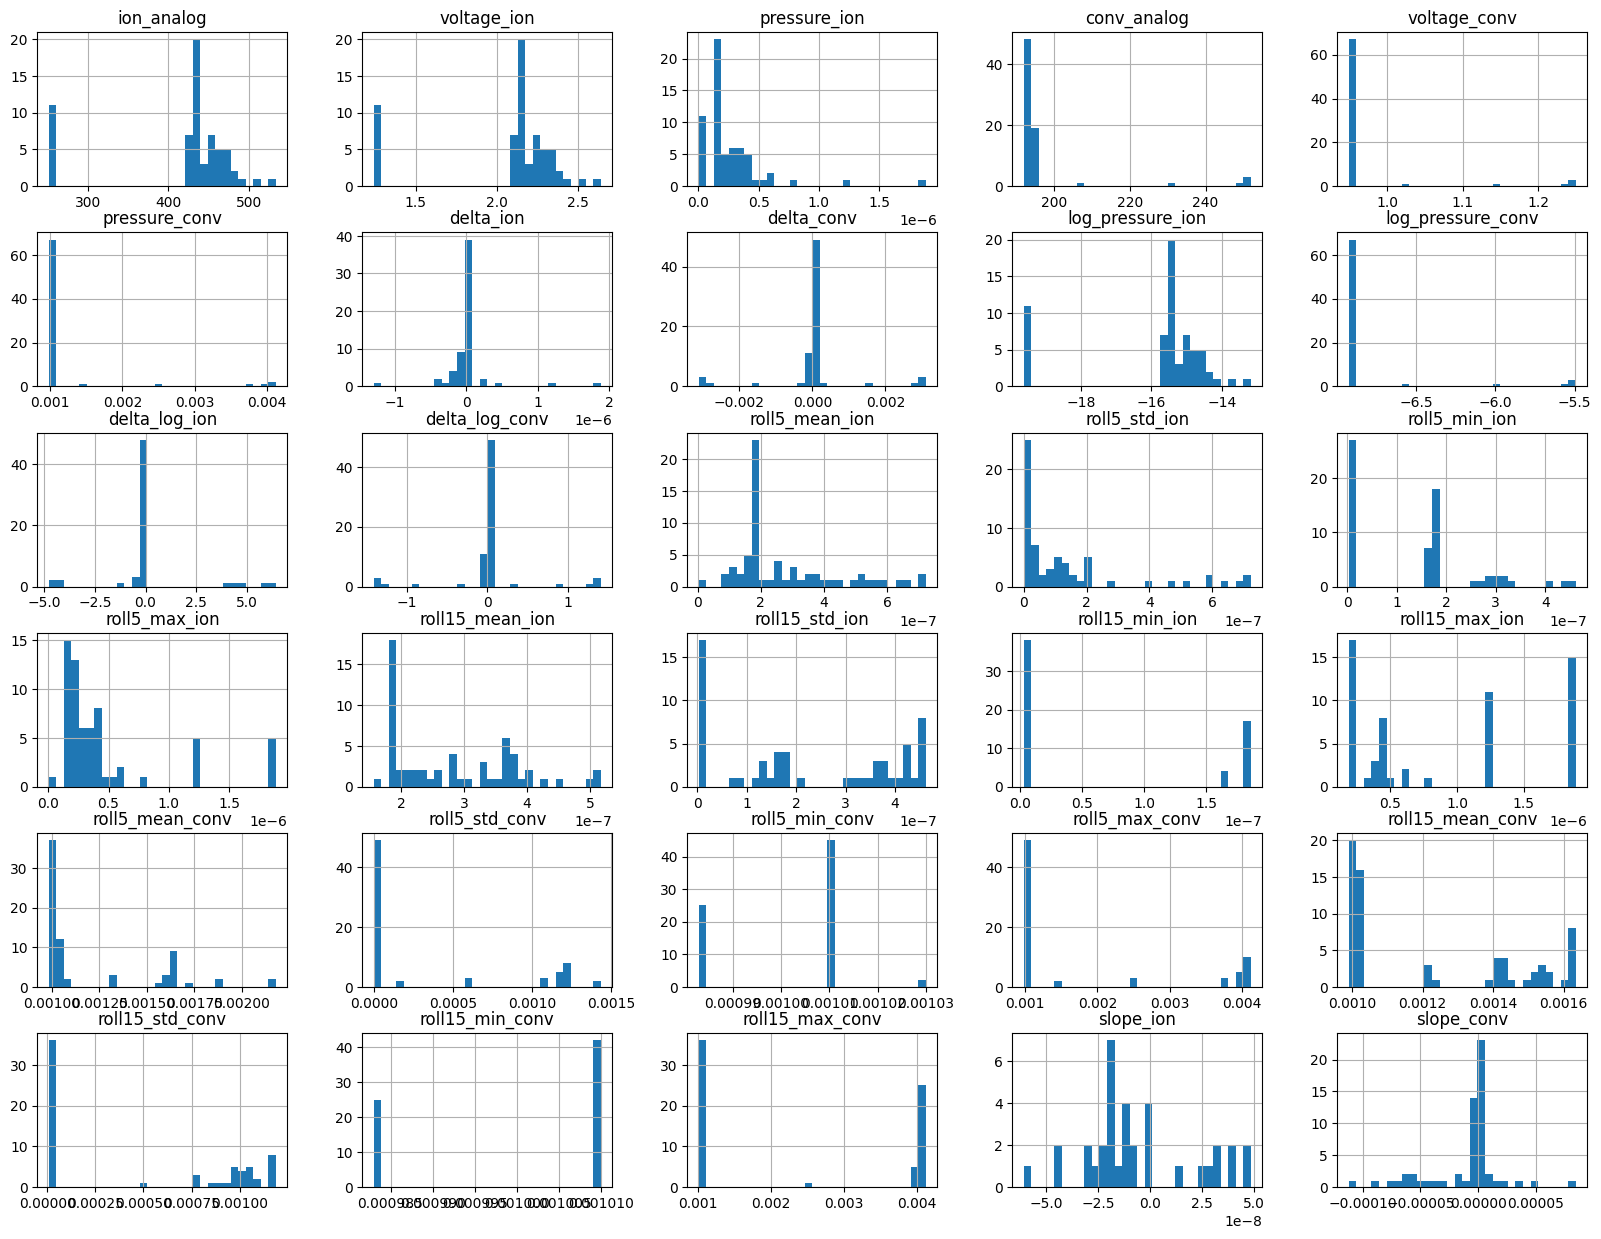

In [84]:
df_cleaned.hist(bins=30, figsize=(20,15))
plt.show()

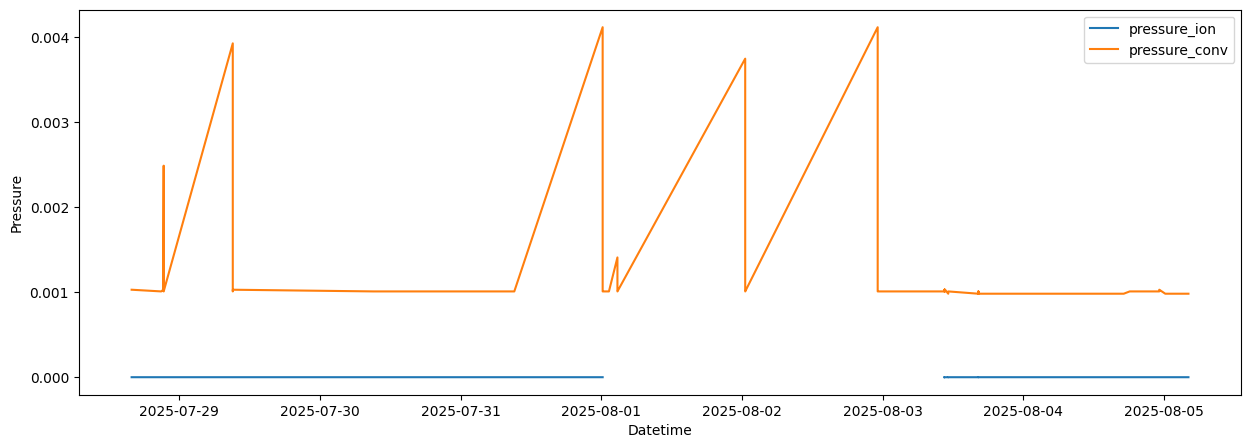

In [69]:
plt.figure(figsize=(15,5))
plt.plot(df_cleaned.index, df_cleaned['pressure_ion'], label='pressure_ion')
plt.plot(df_cleaned.index, df_cleaned['pressure_conv'], label='pressure_conv')
plt.xlabel('Datetime')
plt.ylabel('Pressure')
plt.legend()
plt.show()


<Axes: >

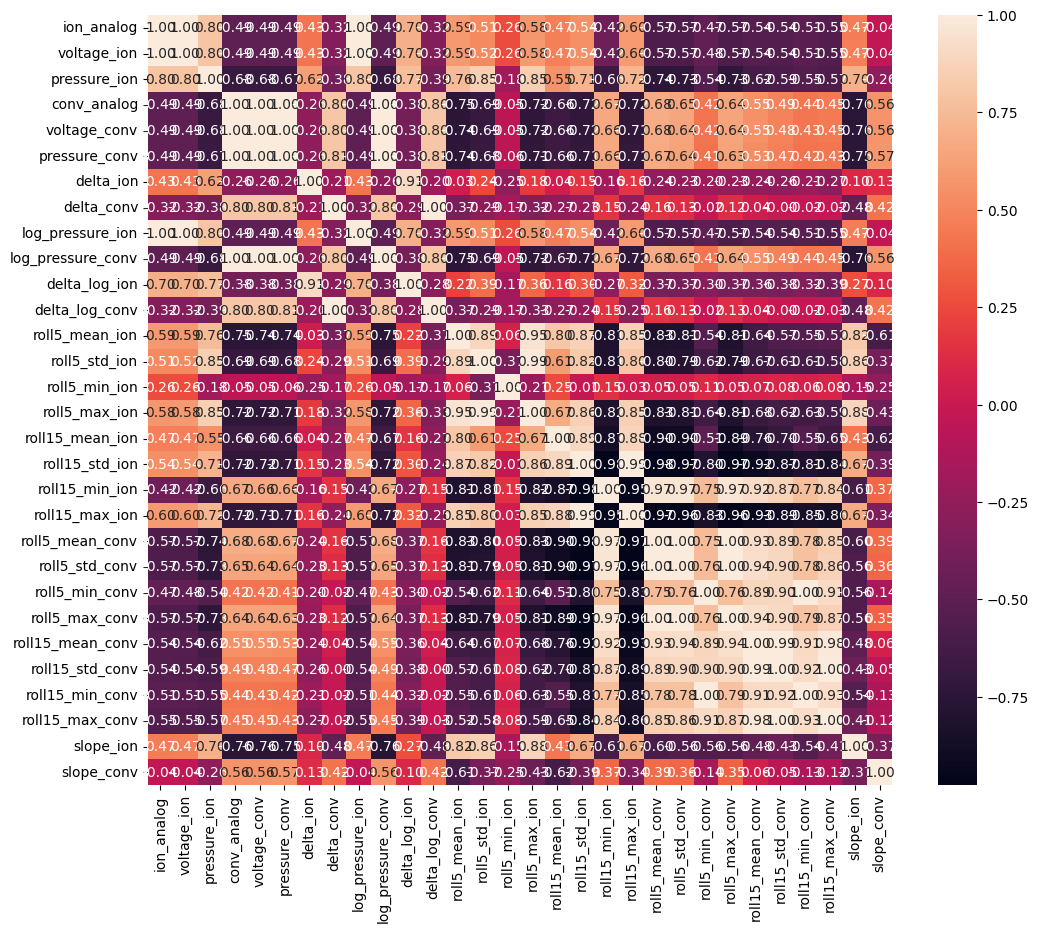

In [70]:
import seaborn as sns
df_heatmapv1 = df_cleaned.select_dtypes(include='number').corr()
# make size bigger
plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmapv1.corr(), annot=True, fmt=".2f")

<Axes: >

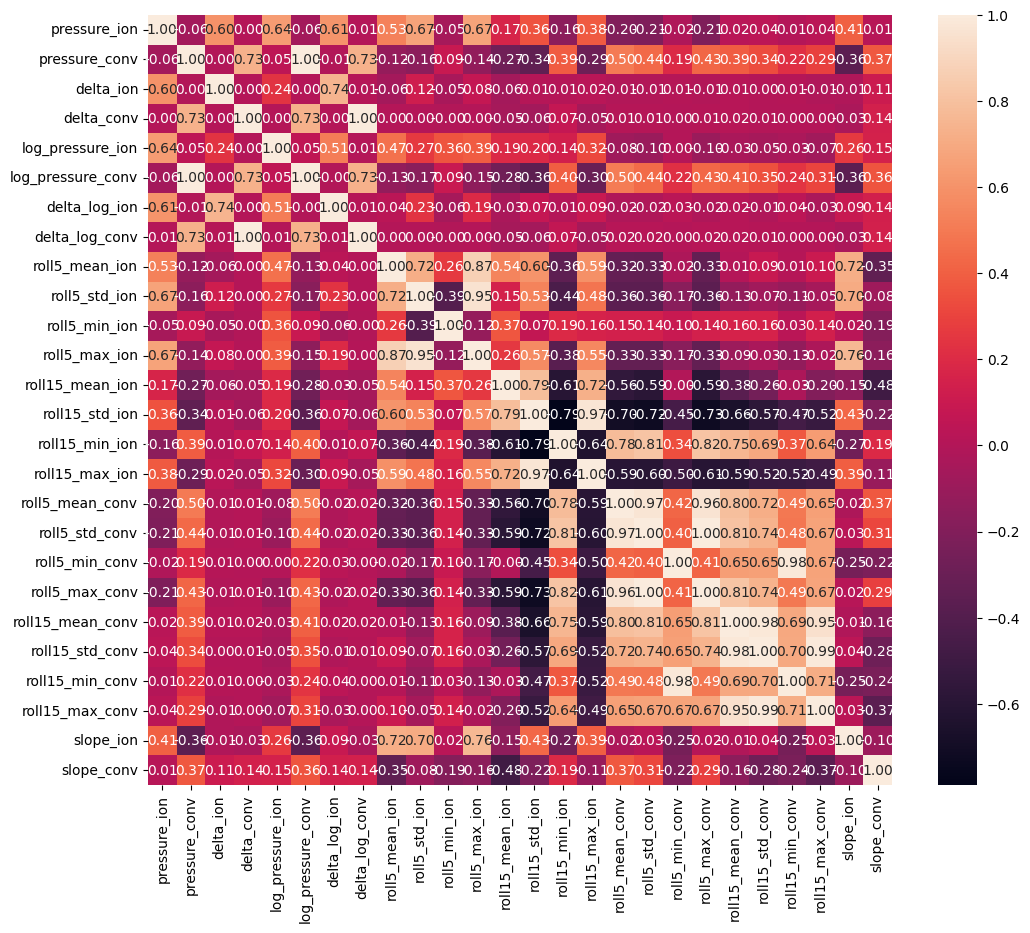

In [82]:
# drop analog from heatmap
df_heatmapv2 = df_cleaned.copy().drop(columns=['conv_analog', 'ion_analog', 'voltage_ion', 'voltage_conv'], errors='ignore')
plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmapv2.select_dtypes(include='number').corr(), annot=True, fmt=".2f")

# Tags analysis

Create binary columns for key tag types

In [72]:
# Parse tags into list
#  Add binary columns for using MultiLabelBinarizer from sklearn
# Derive IG_state & CG_state

df_altered = tag_events(df_cleaned)

df_altered.head()

,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,tags,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll5_mean_ion,roll5_std_ion,roll5_min_ion,roll5_max_ion,roll15_mean_ion,roll15_std_ion,roll15_min_ion,roll15_max_ion,roll5_mean_conv,roll5_std_conv,roll5_min_conv,roll5_max_conv,roll15_mean_conv,roll15_std_conv,roll15_min_conv,roll15_max_conv,slope_ion,slope_conv,tag_list,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,IG_state,CG_state
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-28 15:54:23,432.0,2.13,1.860000e-07,194,0.959,0.00103,"IG on, CG on",NaN,NaN,-15.497519,-6.878196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[IG on, CG on]",1,0,0,0,0,1,0,0,0,IG on,CG on
2025-07-28 15:54:24,432.0,2.13,1.860000e-07,194,0.959,0.00103,"IG on, CG on",0.000000e+00,0.00000,-15.497519,-6.878196,0.000000,0.000000,1.860000e-07,0.000000e+00,1.860000e-07,1.860000e-07,NaN,NaN,NaN,NaN,0.001030,0.000000,0.00103,0.00103,NaN,NaN,NaN,NaN,NaN,NaN,"[IG on, CG on]",1,0,0,0,0,1,0,0,0,IG on,CG on
2025-07-28 20:57:38,434.0,2.14,1.950000e-07,193,0.954,0.00101,"IG on, CG on",9.000000e-09,-0.00002,-15.450266,-6.897805,0.047253,-0.019608,1.890000e-07,4.242641e-09,1.860000e-07,1.950000e-07,NaN,NaN,NaN,NaN,0.001023,0.000009,0.00101,0.00103,NaN,NaN,NaN,NaN,NaN,NaN,"[IG on, CG on]",1,0,0,0,0,1,0,0,0,IG on,CG on
2025-07-28 21:17:40,434.0,2.14,1.950000e-07,194,0.959,0.00103,"IG on, CG on",0.000000e+00,0.00002,-15.450266,-6.878196,0.000000,0.019608,1.905000e-07,4.500000e-09,1.860000e-07,1.950000e-07,NaN,NaN,NaN,NaN,0.001025,0.000009,0.00101,0.00103,NaN,NaN,NaN,NaN,NaN,NaN,"[IG on, CG on]",1,0,0,0,0,1,0,0,0,IG on,CG on
2025-07-28 21:22:28,432.0,2.13,1.860000e-07,231,1.140,0.00249,"IG on, CG on",-9.000000e-09,0.00146,-15.497519,-5.995473,-0.047253,0.882724,1.896000e-07,4.409082e-09,1.860000e-07,1.950000e-07,NaN,NaN,NaN,NaN,0.001318,0.000586,0.00101,0.00249,NaN,NaN,NaN,NaN,NaN,NaN,"[IG on, CG on]",1,0,0,0,0,1,0,0,0,IG on,CG on


# Summary tag frequencies

In [73]:
# Tag frequencies
print("Tag Frequencies:\n", tag_frequencies(df_altered))

Tag Frequencies:
           Tag  Count
0       CG on     73
1       IG on     31
2  IG slow on     18
3      IG off     13
4  IG turn on     10
5     IG fail      5


# Detect anomalies

In [80]:
pd.set_option("display.max_columns", None)
df_altered = detect_anomalies(df_altered)
print(df_altered.shape)
df_altered[['anomaly_if', 'score_if_raw', 'score_if']]

(73, 46)


,anomaly_if,score_if_raw,score_if
datetime,,,
2025-07-28 15:54:23,1,0.136649,-0.136649
2025-07-28 15:54:24,1,0.210110,-0.210110
2025-07-28 20:57:38,1,0.194633,-0.194633
2025-07-28 21:17:40,1,0.203030,-0.203030
2025-07-28 21:22:28,1,0.034979,-0.034979
...,...,...,...
2025-08-04 19:22:17,1,0.233947,-0.233947
2025-08-04 23:10:23,1,0.222614,-0.222614
2025-08-04 23:10:24,1,0.236109,-0.236109


In [75]:
df_altered[df_altered['anomaly_if'] == 1].describe()

,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll5_mean_ion,roll5_std_ion,roll5_min_ion,roll5_max_ion,roll15_mean_ion,roll15_std_ion,roll15_min_ion,roll15_max_ion,roll5_mean_conv,roll5_std_conv,roll5_min_conv,roll5_max_conv,roll15_mean_conv,roll15_std_conv,roll15_min_conv,roll15_max_conv,slope_ion,slope_conv,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,anomaly_if,score_if_raw,score_if
count,63.000000,63.000000,6.300000e+01,72.000000,72.000000,72.000000,6.100000e+01,71.000000,63.000000,72.000000,61.000000,71.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,71.000000,71.000000,71.000000,71.000000,66.000000,66.000000,66.000000,66.000000,3.500000e+01,5.800000e+01,72.000000,72.000000,72.000000,72.000000,72.000000,72.0,72.0,72.0,72.0,72.0,72.000000,72.000000
mean,414.809524,2.048571,2.731090e-07,196.125000,0.969556,0.001157,2.798197e-09,-0.000044,-15.888802,-6.825245,0.064969,-0.020459,2.734344e-07,1.402406e-07,1.334211e-07,4.880205e-07,2.852707e-07,2.247107e-07,6.394224e-08,9.045862e-07,0.001187,0.000324,0.001001,0.001807,0.001221,0.000464,0.001000,0.002393,-5.406274e-09,-1.156687e-05,0.430556,0.166667,0.069444,0.138889,0.250000,1.0,0.0,0.0,0.0,1.0,0.168532,-0.168532
std,77.971843,0.384497,2.917459e-07,12.292145,0.061440,0.000611,3.567017e-07,0.000968,1.774749,0.293346,1.903374,0.460817,1.641185e-07,2.013480e-07,1.278723e-07,5.000993e-07,9.813960e-08,1.779528e-07,8.474055e-08,6.890398e-07,0.000301,0.000511,0.000014,0.001276,0.000252,0.000507,0.000013,0.001523,2.693504e-08,2.991853e-05,0.498629,0.375293,0.255992,0.348257,0.436051,0.0,0.0,0.0,0.0,0.0,0.061707,0.061707
min,251.000000,1.240000,3.020000e-09,192.000000,0.949000,0.000983,-1.297000e-06,-0.003110,-19.618009,-6.924901,-4.778107,-1.405903,3.200000e-09,0.000000e+00,3.020000e-09,3.310000e-09,1.560507e-07,2.571297e-09,3.020000e-09,1.900000e-07,0.000983,0.000000,0.000983,0.000983,0.000990,0.000008,0.000983,0.001010,-6.083214e-08,-1.119286e-04,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.008690,-0.244224
25%,430.000000,2.120000,1.780000e-07,193.000000,0.954000,0.001010,-2.900000e-08,0.000000,-15.541482,-6.897805,-0.092373,0.000000,1.762000e-07,4.409082e-09,3.090000e-09,1.937500e-07,1.882125e-07,4.330916e-09,3.037500e-09,1.950000e-07,0.000996,0.000010,0.000983,0.001010,0.001005,0.000012,0.000983,0.001030,-1.980439e-08,-9.321429e-06,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.134839,-0.220235
50%,432.000000,2.130000,1.860000e-07,193.000000,0.954000,0.001010,-4.000000e-09,0.000000,-15.497519,-6.897805,-0.043803,0.000000,1.896000e-07,4.913400e-08,1.660000e-07,2.830000e-07,2.679507e-07,1.802861e-07,3.090000e-09,5.555000e-07,0.001022,0.000013,0.001010,0.001030,0.001023,0.000021,0.001010,0.001030,-1.215104e-08,-5.875000e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.175549,-0.175549
75%,456.500000,2.255000,3.245000e-07,194.000000,0.959000,0.001030,0.000000e+00,0.000000,-14.941038,-6.878196,0.000000,0.000000,3.445500e-07,1.641129e-07,1.860000e-07,4.320000e-07,3.705453e-07,4.117100e-07,1.820000e-07,1.725000e-06,0.001316,0.000589,0.001010,0.002490,0.001451,0.000995,0.001010,0.004120,6.328839e-09,9.553571e-07,1.000000,0.000000,0.000000,0.000000,0.250000,1.0,0.0,0.0,0.0,1.0,0.220235,-0.134839
max,534.000000,2.640000,1.890000e-06,252.000000,1.250000,0.004120,1.886980e-06,0.003110,-13.178934,-5.491902,6.439075,1.405903,7.230000e-07,7.228254e-07,4.620000e-07,1.890000e-06,5.173429e-07,4.625025e-07,1.860000e-07,1.890000e-06,0.002180,0.001438,0.001030,0.004120,0.001635,0.001188,0.001010,0.004120,4.848393e-08,5.107143e-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.244224,-0.008690


In [76]:
# stats
print(df_altered[["pressure_ion","pressure_conv"]].describe())
print(df_altered["IG_state"].value_counts())

       pressure_ion  pressure_conv
count  6.300000e+01      73.000000
mean   2.731090e-07       0.001197
std    2.917459e-07       0.000699
min    3.020000e-09       0.000983
25%    1.780000e-07       0.001010
50%    1.860000e-07       0.001010
75%    3.245000e-07       0.001030
max    1.890000e-06       0.004120
IG_state
IG on         30
IG slow on    17
IG off        11
IG turn on    10
IG fail        5
Name: count, dtype: int64


In [77]:
#  time vs ion and convectron pressure w event markers
p_time_with_events = plot_time_with_events(
	df_altered,
	savepath=OUTPUT_PLOTS / "plot_time_events.png"
)
# scatter ion vs conv by IG state
p_scatter = scatter_ion_vs_conv_by_state(
	df_altered,
	savepath=OUTPUT_PLOTS / "scatter_ion_vs_conv_by_state.png"
)

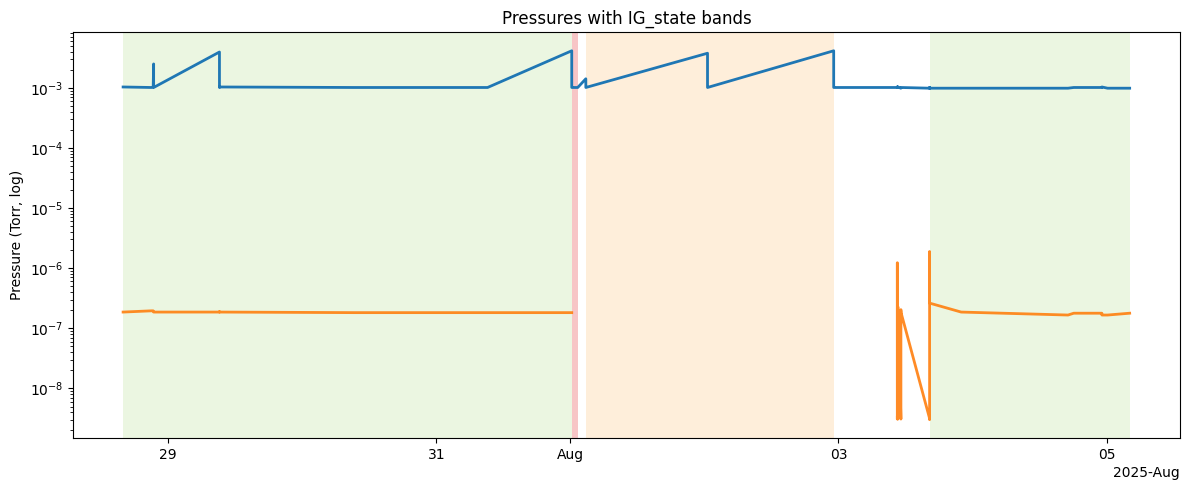

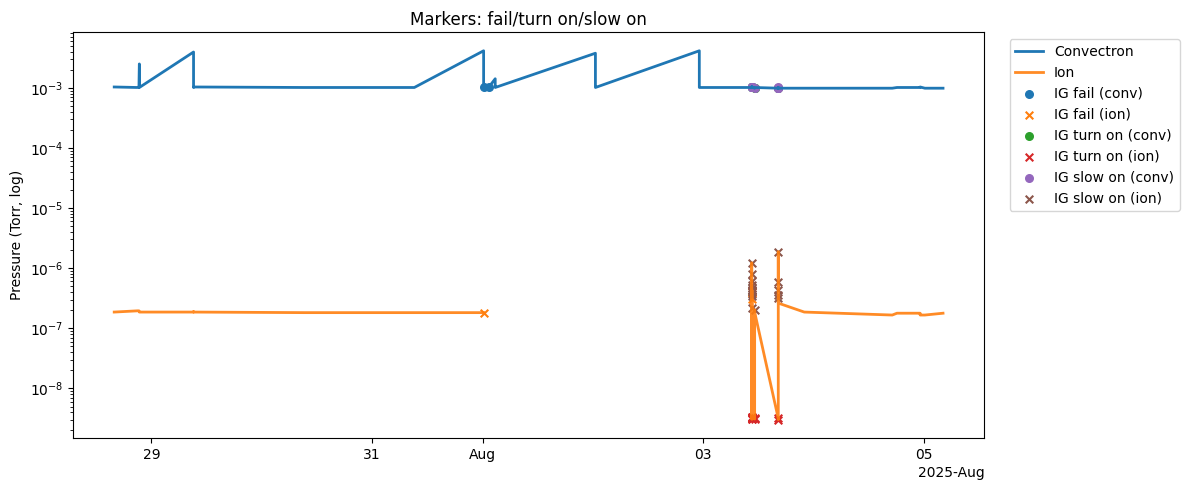

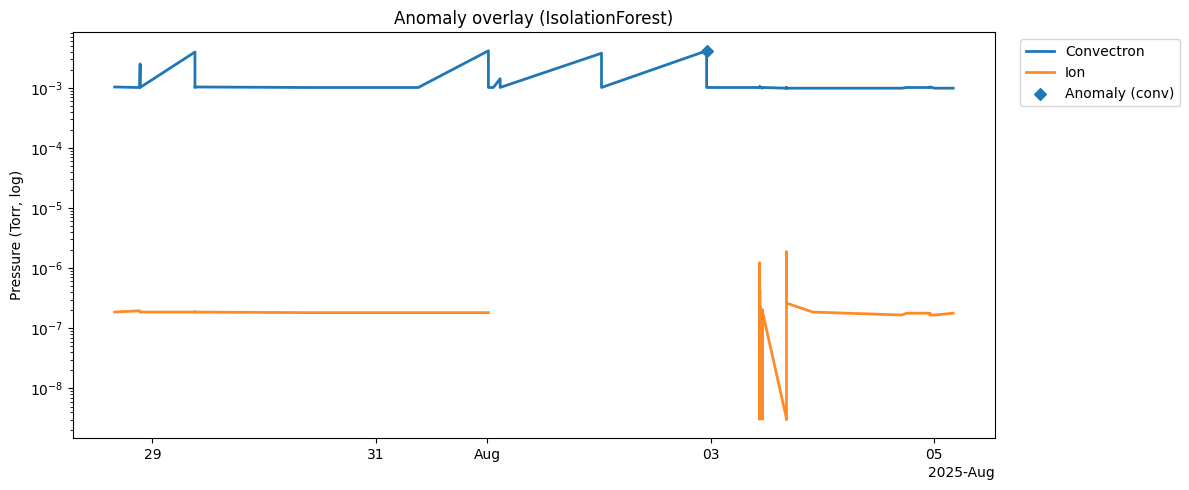

In [78]:

# visuals for EDA
plot_time_with_state_bands(df_altered.reset_index(), title="Pressures with IG_state bands")

plot_time_with_tag_markers(
    df_altered.reset_index(), 
    tags_to_mark=("IG fail", "IG turn on", "IG slow on"),
    title="Markers: fail/turn on/slow on"
)

plot_anomalies(df_altered.reset_index(), title="Anomaly overlay (IsolationForest)", savepath=OUTPUT_PLOTS / "anomalies_overlay.png")


In [79]:
out = DATA_PROCESSED / "processed_from_notebook.csv"
df.to_csv(out, index=False)
out

WindowsPath('../data/processed/processed_from_notebook.csv')